In [1]:
!gdown --id 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
!unzip dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 89.5MB/s]
Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 12.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names=headers, encoding='ISO-8859-1')
df

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [5]:
classes = {class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,1,LONDON MarketWatch -- Share prices ended lower...
4842,0,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,1,Operating profit fell to EUR 35.4 mn from EUR ...
4844,1,Net sales of the Paper segment decreased to EU...


In [6]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

    return text

In [7]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [8]:
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [9]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

In [10]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [11]:
class FinancialNews(Dataset):
    def __init__(
        self,
        X, y,
        word_to_idx,
        max_seq_len,
        transform=None
    ):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)
        text = torch.tensor(text)

        return text, label

In [12]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

In [13]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [15]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

In [16]:
model.eval()

dummy_tensor = torch.randint(10, (1, 10)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 3])


In [17]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [18]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [19]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.0084	Val loss: 0.9589
EPOCH 2:	Train loss: 0.9463	Val loss: 0.9344
EPOCH 3:	Train loss: 0.9315	Val loss: 0.9299
EPOCH 4:	Train loss: 0.9250	Val loss: 0.9292
EPOCH 5:	Train loss: 0.9277	Val loss: 0.9289
EPOCH 6:	Train loss: 0.9220	Val loss: 0.9286
EPOCH 7:	Train loss: 0.9292	Val loss: 0.9286
EPOCH 8:	Train loss: 0.9288	Val loss: 0.9282
EPOCH 9:	Train loss: 0.9306	Val loss: 0.9281
EPOCH 10:	Train loss: 0.9271	Val loss: 0.9281
EPOCH 11:	Train loss: 0.9261	Val loss: 0.9281
EPOCH 12:	Train loss: 0.9322	Val loss: 0.9282
EPOCH 13:	Train loss: 0.9301	Val loss: 0.9278
EPOCH 14:	Train loss: 0.9259	Val loss: 0.9278
EPOCH 15:	Train loss: 0.9356	Val loss: 0.9282
EPOCH 16:	Train loss: 0.9274	Val loss: 0.9281
EPOCH 17:	Train loss: 0.9330	Val loss: 0.9280
EPOCH 18:	Train loss: 0.9309	Val loss: 0.9279
EPOCH 19:	Train loss: 0.9284	Val loss: 0.9278
EPOCH 20:	Train loss: 0.9273	Val loss: 0.9278
EPOCH 21:	Train loss: 0.9301	Val loss: 0.9277
EPOCH 22:	Train loss: 0.9302	Val loss: 0.92

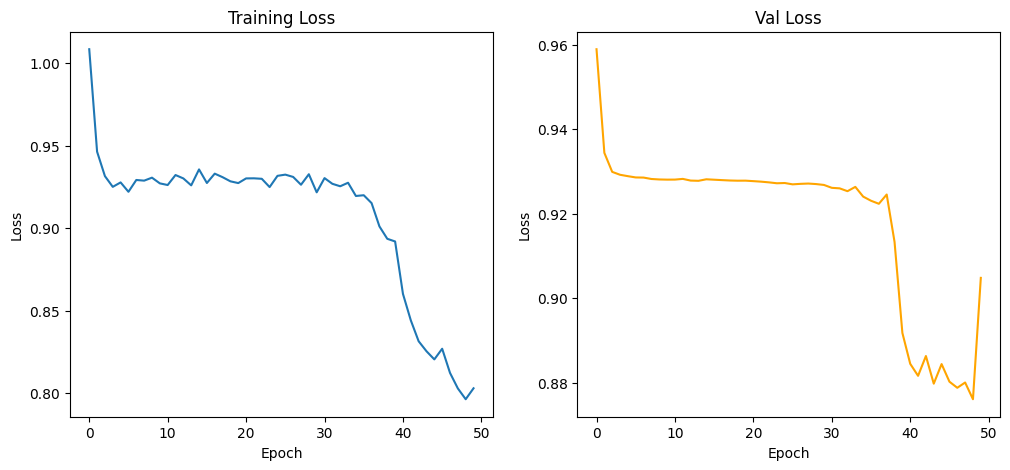

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [22]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6103092783505155
Test accuracy:  0.6069587628865979
